### Train Black Box Neural Network
I am using a black box Neural Network from [Marcotcr](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html). The network favors dog classification and has some depreciated methods. Feel free to choose your own image classification network.

In [25]:
import tensorflow as tf
from nets import inception
from preprocessing import inception_preprocessing
import matplotlib.pyplot as plt
import sys
from skimage.segmentation import mark_boundaries
%matplotlib inline
import numpy as np

slim = tf.contrib.slim


## Change Path to your complete path
sys.path.append('/Users/stronglab2/Documents/Datadolittle/modelinterpretability/data/tf-models-master/slim/')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
session = tf.Session()
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image_raw = tf.image.decode_jpeg(open(f, 'rb').read(), channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [5]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

In [6]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [ ]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

In [ ]:
## Change to your complete path
checkpoints_dir ='/Users/stronglab2/Documents/Datadolittle/modelinterpretability/data/tf-models-master/slim/pretrained/'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)

In [8]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

### Predict on an Image

769 rugby ball 0.005724809
100 goose 0.0061267074
173 whippet 0.0065590027
232 collie 0.11005984
233 Border collie 0.6309783


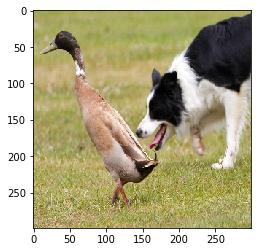

In [10]:
images = transform_img_fn(['../data/duck.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])

image = images[0]

In [11]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

## May take 5 to 10 minutes
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

### Explain Top Class
**Label ID = 233 |** Border collie 0.6309783

**Label ID = 100 |** Goose 0.0061267074

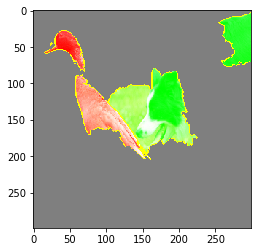

In [16]:
temp, mask = explanation.get_image_and_mask(label=233, positive_only=False, num_features=10, hide_rest=True)
## Toggle Mask, Positive Only, min weight
#min_weight=0.1
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.savefig("../Images/Positive_Doggo.png")

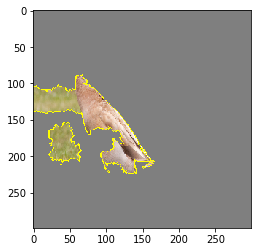

In [19]:
## Rugby Ball
temp, mask = explanation.get_image_and_mask(label=769, positive_only=True, num_features=5, hide_rest=True)
## Toggle Mask, Positive Only, min weight
#min_weight=0.1
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.savefig("../Images/Rugby_Ball.png")

### End of Lime Example